In [19]:
!pip install pretrainedmodels

You should consider upgrading via the 'pip install --upgrade pip' command.


In [20]:
import matplotlib.pyplot as plt
import matplotlib
import argparse 
import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pickle
import random
import pretrainedmodels
import torchvision

matplotlib.style.use('ggplot')

from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm


<div id="2"></div>
# 2 划分数据集

<div id="2.1"></div>
## 2.1 分析数据集

首先读取Caltech-101数据集。并对数据集进行处理，主要提取出数据集中的图像及其对应的类别，并对应保存在变量中。

tar是文件打包工具，可以将多个文件合并为一个文件。打包后的文件名后缀为“tar”。后缀为tar的文件代表未被压缩的tar文件。已被压缩的tar文件则需要追加压缩文件的扩展名，如经过gzip压缩后的tar文件，扩展名变为tar.gz。

In [21]:
import tarfile
with tarfile.open('./101_ObjectCategories.tar.gz', 'r:gz') as tar:
    tar.extractall()

In [22]:
!pip install imutils

You should consider upgrading via the 'pip install --upgrade pip' command.


In [53]:
image_paths = list(paths.list_images('./101_ObjectCategories'))
data = []
labels = []
label_names = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    
    # 删去杂乱类
    if label == 'BACKGROUND_Google':
        continue

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    data.append(image)
    label_names.append(label)
    labels.append(label)


['barrel', 'platypus', 'euphonium', 'okapi', 'lotus', 'yin_yang', 'tick', 'hawksbill', 'menorah', 'nautilus', 'binocular', 'ferry', 'flamingo', 'headphone', 'panda', 'chair', 'sea_horse', 'trilobite', 'stegosaurus', 'ibis', 'accordion', 'bonsai', 'rooster', 'anchor', 'crocodile_head', 'bass', 'electric_guitar', 'mayfly', 'rhino', 'crayfish', 'cellphone', 'brain', 'saxophone', 'minaret', 'wrench', 'octopus', 'brontosaurus', 'wheelchair', 'water_lilly', 'beaver', 'inline_skate', 'helicopter', 'gramophone', 'dolphin', 'butterfly', 'starfish', 'dollar_bill', 'kangaroo', 'umbrella', 'camera', 'wild_cat', 'emu', 'lamp', 'ant', 'Faces', 'cannon', 'hedgehog', 'garfield', 'ewer', 'dragonfly', 'scorpion', 'cup', 'joshua_tree', 'flamingo_head', 'crocodile', 'airplanes', 'pigeon', 'gerenuk', 'buddha', 'dalmatian', 'pizza', 'chandelier', 'revolver', 'crab', 'cougar_body', 'car_side', 'sunflower', 'snoopy', 'llama', 'elephant', 'strawberry', 'lobster', 'pagoda', 'Faces_easy', 'cougar_face', 'laptop'

In [24]:
data = np.array(data)
labels = np.array(labels)

# 图像的类别
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print("数据集共有",len(lb.classes_),"类")

# 储存图像类别的名称
count_arr = []
label_arr = []
for i in range(len(lb.classes_)):
    count = 0
    for j in range(len(label_names)):
        if lb.classes_[i] in label_names[j]:
            count += 1
    count_arr.append(count)
    label_arr.append(lb.classes_[i])

数据集共有 101 类


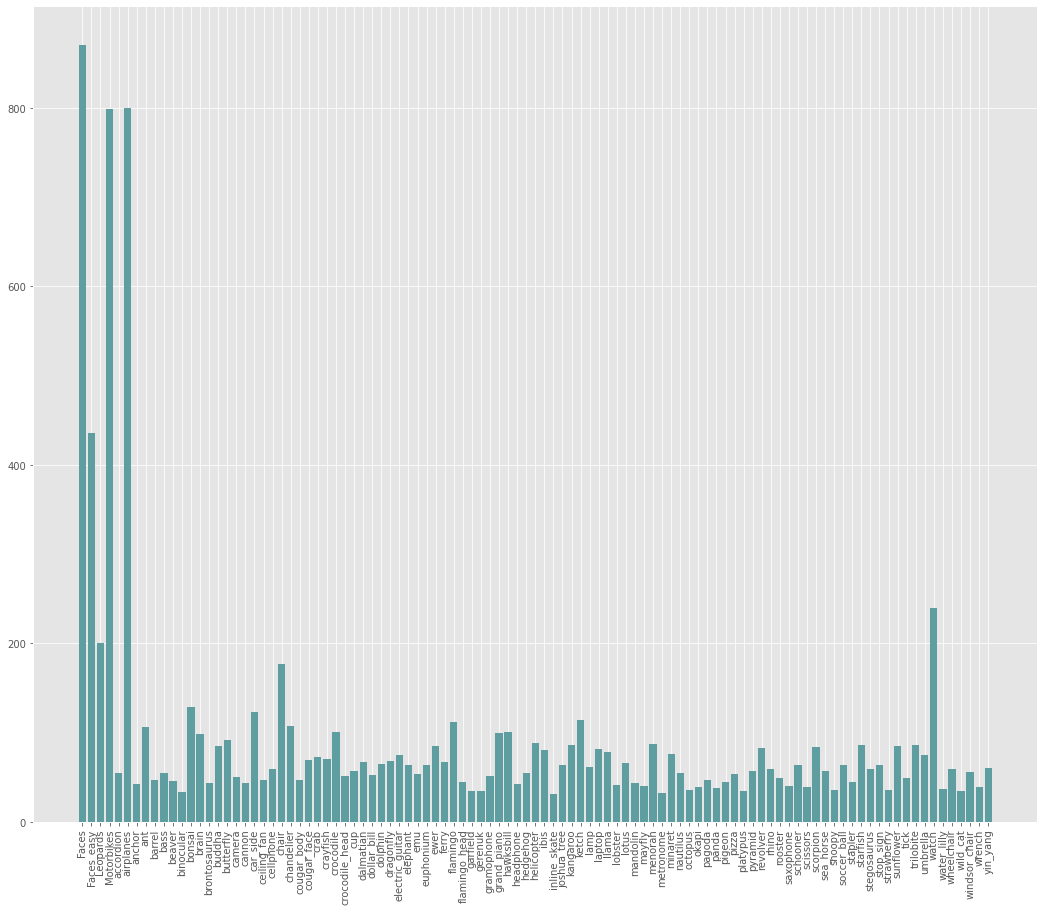

In [25]:
plt.figure(figsize=(18, 15))
plt.bar(label_arr, count_arr,color="cadetblue")
plt.xticks(rotation='vertical')
plt.show()

In [26]:
(X, x_val , Y, y_val) = train_test_split(data, labels, 
                                                    test_size=0.2,  
                                                    stratify=labels,
                                                    random_state=42)

(x_train, x_test, y_train, y_test) = train_test_split(X, Y, 
                                                    test_size=0.25, 
                                                    random_state=42)

print(f"训练集 x_train 图片数 : {x_train.shape}\n验证集 x_test 图片数: {x_test.shape}\n测试集 x_val 图片数: {x_val.shape}")

训练集 x_train 图片数 : (5205,)
验证集 x_test 图片数: (1736,)
测试集 x_val 图片数: (1736,)


In [27]:
# 定义格式转换函数
train_transform = transforms.Compose(
    [transforms.ToPILImage(),
	 transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose(
    [transforms.ToPILImage(),
	 transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

In [28]:
# 转换并保存训练集、验证集、测试集
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data
 
train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
test_data = ImageDataset(x_test, y_test, val_transform)

In [29]:
epochs = 1
batch_size = 16

In [45]:
# 数据集 dataloaders
trainloader = DataLoader(train_data, batch_size=16, shuffle=True)
valloader = DataLoader(val_data, batch_size=16, shuffle=True)
testloader = DataLoader(test_data, batch_size=16, shuffle=False)
oneloader = DataLoader(test_data,batch_size=1,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


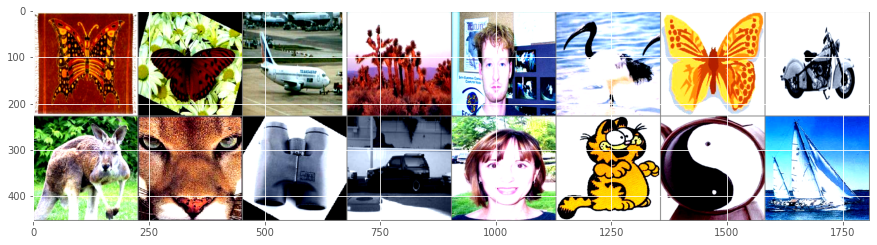

In [31]:
def imshow(img):
    plt.figure(figsize=(15, 12))
    img = img / 2 + 0.5   
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    plt.show()


# 随机获取一些图像
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 显示图像
imshow(torchvision.utils.make_grid(images))

In [32]:
# 定义随机种子
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True # 所有的图像大小相同，所以参数可以为True
SEED=42
seed_everything(SEED=SEED)


In [33]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [35]:
class ResNet34(nn.Module):
    def __init__(self, pretrained):
      # 调用在ImagetNet上预训练的ResNet模型的权重
        super(ResNet34, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained=None)
        
        # 改变全连接层的输出
        self.l0 = nn.Linear(512, len(lb.classes_))
        # 设置dropout层的参数
        self.dropout = nn.Dropout2d(0.4)
    
    # 对在ImageNet上训练得到的ResNet模型进行微调
    def forward(self, x):
        # 得到图像数据
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        # 在全连接层前接入Dropout层
        x = self.dropout(x)
        # 连接全连接层
        l0 = self.l0(x)
        return l0

# 显示模型构造
model = ResNet34(pretrained=True).to(device)
print(model)


ResNet34(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [36]:
# 定义优化参数的方法
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# 定义损失函数
criterion = nn.CrossEntropyLoss()

In [37]:
# 训练函数
def fit(model, dataloader):
    print('训练')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    # 对每个批次（batch）进行训练
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        
        # 梯度值更新为零
        optimizer.zero_grad()
        outputs = model(data)

        # 计算损失值
        loss = criterion(outputs, torch.max(target, 1)[1])
        train_running_loss += loss.item()
        
        # 得到分类结果
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        # 通过反向传播更新参数
        loss.backward()
        optimizer.step()
    
    # 每次训练完所有数据（一次epoch）后，计算损失值和分类准确率
    train_loss = train_running_loss/len(dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(dataloader.dataset)
    
    print(f"训练集 损失值: {train_loss:.4f}, 训练集 准确率: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

In [38]:
# 验证函数
def validate(model, dataloader):
    print('验证')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, torch.max(target, 1)[1])
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        val_loss = val_running_loss/len(dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(dataloader.dataset)
        print(f'验证集 损失值: {val_loss:.4f}, 验证集 准确率: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy



In [39]:
print(f"训练集包含 {len(train_data)} 张图像，验证集包含 {len(val_data)} 张图像")

# 训练模型
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    
    # 调用训练函数和验证函数
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, valloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

end = time.time()

# 显示训练模型需要的时间
print((end-start)/60, 'minutes')

  0%|          | 0/325 [00:00<?, ?it/s]

训练集包含 5205 张图像，验证集包含 1736 张图像
Epoch 1 of 1
训练


326it [06:39,  1.23s/it]                         
  0%|          | 0/108 [00:00<?, ?it/s]

训练集 损失值: 0.1047, 训练集 准确率: 67.55
验证


109it [00:45,  2.40it/s]                         

验证集 损失值: 0.0262, 验证集 准确率: 91.53
7.420129640897115 minutes


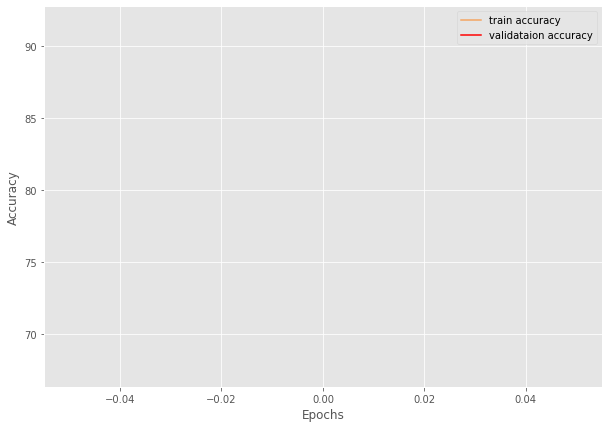

In [40]:
# 分类准确率折线图
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='sandybrown', label='train accuracy')
plt.plot(val_accuracy, color='red', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

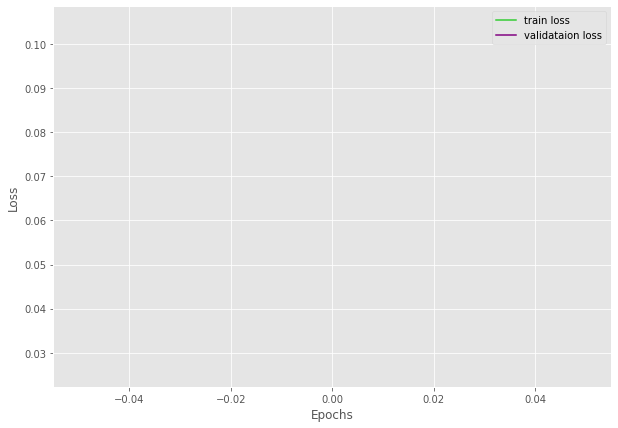

In [41]:
# 损失值折线图
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='limegreen', label='train loss')
plt.plot(val_loss, color='purple', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [42]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, target = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == torch.max(target, 1)[1]).sum().item()

print('模型在测试集上的分类准确率 : %0.3f %%' % (
    100 * correct / total))

模型在测试集上的分类准确率 : 91.532 %


In [ ]:
n = 0 
with torch.no_grad():
    for data in testloader:
      inputs, target = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      # 随机选取每个批次(epoch)中的一张图像，观察预测结果
      i = random.sample(range(0,15),1)
      i = i[0]
      print("图像",n); n = n+1
      print("预测图像属于:",label_names[predicted[i]],"类;"," 实际图像属于:",label_names[torch.max(target, 1)[1][i]],"类")

图像 0
预测图像属于: pyramid 类;  实际图像属于: pyramid 类
图像 1
预测图像属于: pyramid 类;  实际图像属于: pyramid 类
图像 2
预测图像属于: pyramid 类;  实际图像属于: pyramid 类
图像 3
预测图像属于: pyramid 类;  实际图像属于: pyramid 类
图像 4
预测图像属于: nautilus 类;  实际图像属于: nautilus 类
图像 5
预测图像属于: pyramid 类;  实际图像属于: pyramid 类
图像 6
预测图像属于: nautilus 类;  实际图像属于: nautilus 类
图像 7
预测图像属于: pyramid 类;  实际图像属于: pyramid 类
图像 8
预测图像属于: pyramid 类;  实际图像属于: pyramid 类
图像 9
预测图像属于: pyramid 类;  实际图像属于: pyramid 类
图像 10
预测图像属于: pyramid 类;  实际图像属于: pyramid 类
图像 11
预测图像属于: pyramid 类;  实际图像属于: pyramid 类
图像 12
预测图像属于: pyramid 类;  实际图像属于: pyramid 类
图像 13
预测图像属于: nautilus 类;  实际图像属于: nautilus 类
图像 14
预测图像属于: nautilus 类;  实际图像属于: nautilus 类
图像 15
预测图像属于: nautilus 类;  实际图像属于: nautilus 类
图像 16
预测图像属于: pyramid 类;  实际图像属于: pyramid 类
图像 17
预测图像属于: nautilus 类;  实际图像属于: nautilus 类
图像 18
预测图像属于: nautilus 类;  实际图像属于: pyramid 类
图像 19
预测图像属于: pyramid 类;  实际图像属于: pyramid 类
图像 20
预测图像属于: pyramid 类;  实际图像属于: nautilus 类
图像 21
预测图像属于: pyramid 类;  实际图像属于: pyramid 类
图像 22
预测图像属于: pyramid 类;  实际

tensor([[[[ 0.8961,  1.1529,  1.2899,  ..., -0.4054, -0.5082, -0.5596],
          [ 0.6221,  1.1529,  1.3242,  ..., -0.1828, -0.1314, -0.1143],
          [ 0.2282,  0.8618,  1.2043,  ..., -0.2171, -0.0972, -0.0116],
          ...,
          [-0.2513, -0.2513, -0.3712,  ...,  0.7248,  0.7762,  0.7419],
          [-0.1486, -0.1143, -0.3027,  ...,  0.4679,  0.5878,  0.5878],
          [-0.1314, -0.1828, -0.3027,  ...,  0.1939,  0.4337,  0.4508]],

         [[ 0.9755,  1.2381,  1.3782,  ..., -0.3375, -0.4251, -0.4776],
          [ 0.6954,  1.2381,  1.4132,  ..., -0.1099, -0.0574, -0.0224],
          [ 0.2927,  0.9405,  1.2906,  ..., -0.1450, -0.0049,  0.0826],
          ...,
          [ 0.0651,  0.0651, -0.0399,  ...,  0.7129,  0.7129,  0.6954],
          [ 0.1702,  0.2052,  0.0301,  ...,  0.4678,  0.5728,  0.5903],
          [ 0.1877,  0.1527,  0.0301,  ...,  0.2227,  0.4328,  0.4678]],

         [[ 1.0017,  1.2631,  1.4025,  ..., -0.4275, -0.5670, -0.6367],
          [ 0.7228,  1.2631,  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


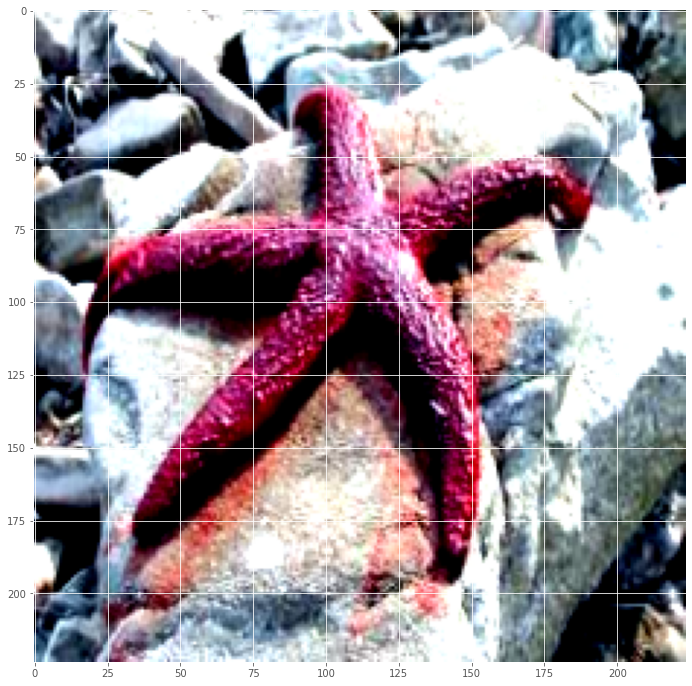

tensor([86])
预测图像属于: windsor_chair 类;  实际图像属于: windsor_chair 类


In [54]:
model.eval()
with torch.no_grad():
    for data in oneloader:
      inputs, target = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
      print(inputs)
      print(target)
      outputs = model(inputs)
      imshow(inputs[0])
      predicted = torch.argmax(outputs.data, 1)
      print(predicted)
      print("预测图像属于:",label_names[predicted[0]],"类;"," 实际图像属于:",label_names[torch.argmax(target, 1)[0]],"类")
      break